In [1]:
#https://developers.google.com/earth-engine/guides/python_install
#   https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
%matplotlib inline


#EE needs to go last
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VNBvLl3GLcp_M_nOg0k_-Q0bqVUl2EZVcwSPVBOfRkpuutSYrue_-Y

Successfully saved authorization token.


# Use Google Earth Engine to collect data for a point



In [145]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2023-01-01'

# https://developers.google.com/earth-engine/datasets/catalog/ - find datasets here

#NLDAS precip for SLC
temp = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('temperature').filterDate(i_date, f_date)

# Import the MODIS land cover collection. - dynamic
#lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection. - dynamic
lst = ee.ImageCollection('MODIS/006/MOD11A1').select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

# Import the USGS ground elevation image.- stationary (hopefully...)
#elv = ee.Image('USGS/SRTMGL1_003')

temp

In [147]:
# Define slc location of interest as a point near  Salt Lake City.
u_lon = -111.9356
u_lat = 40.7583
u_poi = ee.Geometry.Point(u_lon, u_lat)

scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
#elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
#print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Calculate and print the mean value of the LST collection at the point.
temp_urban_point = temp.mean().sample(u_poi, scale).first().get('temperature').getInfo()
print('Average temperature at SLC point:', round(temp_urban_point, 2), '°C')

# Print the land cover type at the point.
#lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
#print('Land cover value at urban point is:', lc_urban_point)

Average daytime LST at urban point: 30.04 °C
Average temperature at SLC point: 11.85 °C


In [123]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()
temp_u_poi = temp.getRegion(u_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]
#temp_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  -111.93457597771298,
  40.76105601692329,
  1483228800000,
  None,
  2],
 ['2017_01_02',
  -111.93457597771298,
  40.76105601692329,
  1483315200000,
  13247,
  73],
 ['2017_01_03',
  -111.93457597771298,
  40.76105601692329,
  1483401600000,
  None,
  2],
 ['2017_01_04',
  -111.93457597771298,
  40.76105601692329,
  1483488000000,
  None,
  2]]

In [124]:
#can these be made into a package?

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df



def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius


In [142]:
#Convert pointer object array to dataframe to work with

lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])
temp_df_urban = ee_array_to_df(temp_u_poi,['temperature'])


#resample to the desired temporal scale, take the respective statistic from the data of resampling
temporal_resample = 'M'

#NLDAS Temperature
temp_df_urban.set_index('datetime', inplace = True)
temp_df_urban = temp_df_urban.resample(temporal_resample).max()
temp_df_urban.reset_index(inplace = True)

#Modis Temperature
# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

#make the datetime column the index for plotting
lst_df_urban.set_index('datetime', inplace = True)
lst_df_urban = lst_df_urban.resample(temporal_resample).max()
lst_df_urban.reset_index(inplace=True)


#make columns for Fahrenheit
lst_df_urban['LST_Day_1km_F'] = (lst_df_urban['LST_Day_1km']*9/5)+32 
temp_df_urban['temperature_F'] = (temp_df_urban['temperature']*9/5)+32 

C:\Users\rjohnson18\AppData\Local\Temp\ipykernel_3864\1366607481.py:98: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Figures/GEE_NLDAS_MODIS_temp.png', dpi = 600, box_inches = 'tight')


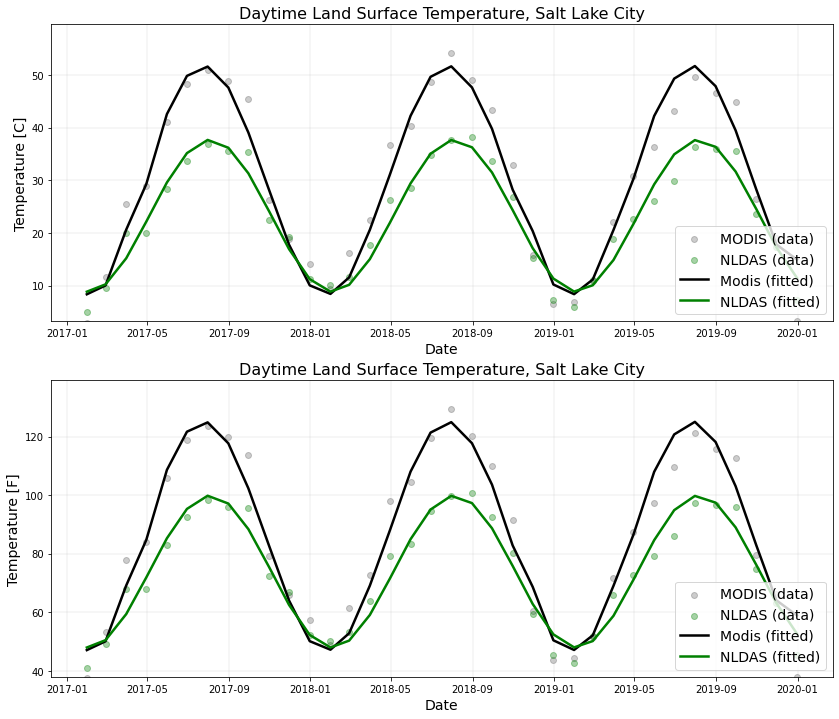

In [155]:

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(temp_df_urban['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(temp_df_urban['temperature'].apply(float))  # rural

y_data_u_F = np.asanyarray(lst_df_urban['LST_Day_1km_F'].apply(float))  # urban
y_data_r_F = np.asanyarray(temp_df_urban['temperature_F'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

params_u_F, params_covariance_u_F = optimize.curve_fit(
    fit_func, x_data_u, y_data_u_F, p0=[lst0, delta_lst, tau, phi])
params_r_F, params_covariance_r_F = optimize.curve_fit(
    fit_func, x_data_r, y_data_r_F, p0=[lst0, delta_lst, tau, phi])



# Subplots.
fig, ax = plt.subplots(2,1, figsize=(14, 12))
fig.patch.set_facecolor('white')
#set min/max for y-axis

ymin = min(min(lst_df_urban['LST_Day_1km']), min(temp_df_urban['temperature']))*1.1
ymax = max(max(lst_df_urban['LST_Day_1km']), max(temp_df_urban['temperature']))*1.1

ymin_F = (ymin*9/5)+32
ymax_F = (ymax*9/5)+32

# Add scatter plots.
ax[0].scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='MODIS (data)')
ax[0].scatter(temp_df_urban['datetime'], temp_df_urban['temperature'],
           c='green', alpha=0.35, label='NLDAS (data)')

# Add fitting curves.
ax[0].plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Modis (fitted)', color='black', lw=2.5)
ax[0].plot(temp_df_urban['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='NLDAS (fitted)', color='green', lw=2.5)

# Add some parameters.
ax[0].set_title('Daytime Land Surface Temperature, Salt Lake City', fontsize=16)
ax[0].set_xlabel('Date', fontsize=14)
ax[0].set_ylabel('Temperature [C]', fontsize=14)
ax[0].set_ylim(ymin, ymax)

#add freezing pt horizontal line
ax[0].hlines(y=0, xmin=min(lst_df_urban['datetime']), xmax=max(lst_df_urban['datetime']), linewidth=1, color='blue')
ax[0].grid(lw=0.2)
ax[0].legend(fontsize=14, loc='lower right')



#Make plot for fahrenheit
ax[1].scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km_F'],
           c='black', alpha=0.2, label='MODIS (data)')
ax[1].scatter(temp_df_urban['datetime'], temp_df_urban['temperature_F'],
           c='green', alpha=0.35, label='NLDAS (data)')

# Add fitting curves.
ax[1].plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u_F[0], params_u_F[1], params_u_F[2], params_u_F[3]),
        label='Modis (fitted)', color='black', lw=2.5)
ax[1].plot(temp_df_urban['datetime'],
        fit_func(x_data_r, params_r_F[0], params_r_F[1], params_r_F[2], params_r_F[3]),
        label='NLDAS (fitted)', color='green', lw=2.5)

# Add some parameters.
ax[1].set_title('Daytime Land Surface Temperature, Salt Lake City', fontsize=16)
ax[1].set_xlabel('Date', fontsize=14)
ax[1].set_ylabel('Temperature [F]', fontsize=14)
ax[1].set_ylim(ymin_F, ymax_F)

#add freezing pt horizontal line
ax[1].hlines(y=32, xmin=min(lst_df_urban['datetime']), xmax=max(lst_df_urban['datetime']), linewidth=1, color='blue')
ax[1].grid(lw=0.2)
ax[1].legend(fontsize=14, loc='lower right')

plt.savefig('Figures/GEE_NLDAS_MODIS_temp.png', dpi = 600, box_inches = 'tight')

plt.show()

In [137]:
temp_df_urban

,datetime,time,temperature
0,2017-01-01,1483311600000,-0.16
1,2017-01-02,1483398000000,0.13
2,2017-01-03,1483484400000,0.76
3,2017-01-04,1483570800000,2.63
4,2017-01-05,1483657200000,2.68
...,...,...,...
1090,2019-12-27,1577487600000,0.98
1091,2019-12-28,1577574000000,-0.89
1092,2019-12-29,1577660400000,-3.03
1093,2019-12-30,1577746800000,0.41


In [134]:
x_data_u

array([1.4833152e+12, 1.4836608e+12, 1.4846112e+12, 1.4846976e+12,
       1.4868576e+12, 1.4869440e+12, 1.4870304e+12, 1.4871168e+12,
       1.4884128e+12, 1.4884992e+12, 1.4885856e+12, 1.4887584e+12,
       1.4888448e+12, 1.4890176e+12, 1.4891904e+12, 1.4893632e+12,
       1.4894496e+12, 1.4895360e+12, 1.4896224e+12, 1.4897088e+12,
       1.4898816e+12, 1.4903136e+12, 1.4904864e+12, 1.4906592e+12,
       1.4907456e+12, 1.4910048e+12, 1.4911776e+12, 1.4912640e+12,
       1.4916096e+12, 1.4916960e+12, 1.4917824e+12, 1.4919552e+12,
       1.4920416e+12, 1.4922144e+12, 1.4923008e+12, 1.4927328e+12,
       1.4928192e+12, 1.4935968e+12, 1.4937696e+12, 1.4938560e+12,
       1.4939424e+12, 1.4941152e+12, 1.4942880e+12, 1.4943744e+12,
       1.4944608e+12, 1.4945472e+12, 1.4948064e+12, 1.4952384e+12,
       1.4954112e+12, 1.4954976e+12, 1.4955840e+12, 1.4958432e+12,
       1.4959296e+12, 1.4960160e+12, 1.4961024e+12, 1.4963616e+12,
       1.4964480e+12, 1.4965344e+12, 1.4966208e+12, 1.4967072e